In [1]:
import scanpy as sc
from perturbench.data.datasplitter import PerturbationDataSplitter
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import yaml
from omegaconf import OmegaConf
import os
import scipy.sparse as sp

In [2]:
replogle = sc.read_h5ad('/gpfs/home/asun/jin_lab/perturbench/0_datasets/replogle.h5ad')


In [5]:
replogle.obs["gene"].value_counts().sum()

20732

In [8]:
replogle.write_h5ad("/gpfs/home/asun/jin_lab/perturbench/0_datasets/replogle_subset_seed2_with_ctrls_sparse.h5ad")

In [2]:
replogle = sc.read_h5ad('/gpfs/home/asun/jin_lab/perturbench/0_datasets/replogle.h5ad')


In [7]:
import numpy as np
import pandas as pd

def select_perturbations_greedy(adata, target_n, k=11, obs_key="condition", random_state=42):
    """
    Select k perturbations whose total cell count is as close as possible to target_n
    using a simple greedy heuristic (under target first, then fill to k with smallest left).

    Parameters
    ----------
    adata : AnnData
        Your dataset; counts per perturbation taken from adata.obs[obs_key].
    target_n : int
        Desired total number of cells across the selected perturbations.
    k : int, default 11
        Number of perturbations to select.
    obs_key : str, default "condition"
        obs column that encodes the perturbation label.
    random_state : int
        Shuffles the order to avoid bias among ties.

    Returns
    -------
    chosen : list[str]
        Selected perturbation labels (length k).
    total_cells : int
        Sum of cells across the chosen perturbations.
    counts_df : pd.DataFrame
        DataFrame with columns ['perturbation','n_cells'] (shuffled order used).
    """
    # counts per perturbation
    counts = adata.obs[obs_key].value_counts()
    counts_df = counts.reset_index()
    counts_df.columns = ["perturbation", "n_cells"]

    # shuffle to avoid systematic bias
    counts_df = counts_df.sample(frac=1, random_state=random_state).reset_index(drop=True)

    chosen = []
    total = 0

    # pass 1: add while staying <= target
    for _, row in counts_df.iterrows():
        if len(chosen) >= k:
            break
        if total + row["n_cells"] <= target_n:
            chosen.append(row["perturbation"])
            total += row["n_cells"]

    # pass 2: if we still need more, add smallest remaining (may exceed target)
    if len(chosen) < k:
        remaining = counts_df[~counts_df["perturbation"].isin(chosen)].sort_values("n_cells")
        for _, row in remaining.iterrows():
            if len(chosen) >= k:
                break
            chosen.append(row["perturbation"])
            total += row["n_cells"]

    return chosen, int(total), counts_df

In [17]:
import numpy as np
import pandas as pd
import itertools

def select_perturbations_closest(adata, target_n, k=11, obs_key="condition", random_state=42, max_combos=100_000):
    """
    Select k perturbations whose total cell count is as close as possible to target_n.
    Tries exact search if feasible, otherwise falls back to greedy + local refinement.

    Parameters
    ----------
    adata : AnnData
        Your dataset; counts per perturbation taken from adata.obs[obs_key].
    target_n : int
        Desired total number of cells across the selected perturbations.
    k : int, default 11
        Number of perturbations to select.
    obs_key : str, default "condition"
        obs column that encodes the perturbation label.
    random_state : int
        For reproducibility in fallback greedy step.
    max_combos : int
        Maximum number of combinations to brute force. If number of possible
        combinations (n choose k) <= max_combos, we do an exact search.

    Returns
    -------
    chosen : list[str]
        Selected perturbation labels (length k).
    total_cells : int
        Sum of cells across the chosen perturbations.
    counts_df : pd.DataFrame
        DataFrame with ['perturbation','n_cells'].
    """

    counts = adata.obs[obs_key].value_counts()
    counts_df = counts.reset_index()
    counts_df.columns = ["perturbation", "n_cells"]

    n_perts = len(counts_df)
    rng = np.random.default_rng(random_state)

    # --- 1) exact search if feasible ---
    from math import comb
    if comb(n_perts, k) <= max_combos:
        best = None
        for combo in itertools.combinations(counts_df.itertuples(index=False), k):
            total = sum(c.n_cells for c in combo)
            diff = abs(total - target_n)
            if best is None or diff < best[0]:
                best = (diff, total, [c.perturbation for c in combo])
                if diff == 0:
                    break  # perfect match
        chosen = best[2]
        total = best[1]
        return chosen, total, counts_df

    # --- 2) greedy fallback ---
    counts_df = counts_df.sample(frac=1, random_state=random_state).reset_index(drop=True)
    chosen, total = [], 0
    for _, row in counts_df.iterrows():
        if len(chosen) >= k:
            break
        if total + row["n_cells"] <= target_n:
            chosen.append(row["perturbation"])
            total += row["n_cells"]

    if len(chosen) < k:
        remaining = counts_df[~counts_df["perturbation"].isin(chosen)].sort_values("n_cells")
        for _, row in remaining.iterrows():
            if len(chosen) >= k:
                break
            chosen.append(row["perturbation"])
            total += row["n_cells"]

    return chosen, int(total), counts_df

In [24]:
import numpy as np
import pandas as pd

def select_perturbations_range(adata, k=11, obs_key="condition",
                               min_cells=1000, max_cells=5000,
                               random_state=42):
    """
    Randomly select k perturbations that each have between min_cells and max_cells cells.

    Parameters
    ----------
    adata : AnnData
        Your dataset.
    k : int
        Number of perturbations to select.
    obs_key : str
        Column in adata.obs that contains perturbation labels.
    min_cells : int
        Minimum number of cells required for a perturbation.
    max_cells : int
        Maximum number of cells allowed for a perturbation.
    random_state : int
        Random seed for reproducibility.

    Returns
    -------
    chosen : list[str]
        Selected perturbation labels (length k).
    total_cells : int
        Total number of cells across the chosen perturbations.
    eligible : pd.DataFrame
        DataFrame of perturbations and cell counts after filtering.
    """
    counts = adata.obs[obs_key].value_counts()
    counts_df = counts.reset_index()
    counts_df.columns = ["perturbation", "n_cells"]

    # filter by range
    eligible = counts_df.query("@min_cells <= n_cells <= @max_cells")

    if len(eligible) < k:
        raise ValueError(f"Only {len(eligible)} perturbations eligible, cannot select {k}.")

    chosen_df = eligible.sample(n=k, random_state=random_state)
    chosen = chosen_df["perturbation"].tolist()
    total_cells = int(chosen_df["n_cells"].sum())

    return chosen, total_cells, eligible

In [14]:
import numpy as np
import pandas as pd

def select_perturbations_range(
    adata,
    k=11,
    obs_key="gene",
    cell_line_key="cell_line",
    min_cells=1000,
    max_cells=8000,
    required_cell_lines=None,   # None -> use all cell lines present in adata.obs[cell_line_key]
    random_state=42,
):
    """
    Randomly select k perturbations that:
      (1) are observed in EVERY required cell line (>=1 cell per cell line), and
      (2) have total cells between min_cells and max_cells (overall, across all lines).

    Parameters
    ----------
    adata : AnnData
    k : int
    obs_key : str
        Column with perturbation labels.
    cell_line_key : str
        Column with cell-line labels.
    min_cells, max_cells : int
        Range for TOTAL cells per perturbation (sum across lines).
    required_cell_lines : list[str] | None
        If None, all unique cell lines in `adata.obs[cell_line_key]` are required.
    random_state : int

    Returns
    -------
    chosen : list[str]
        Selected perturbation labels (length k).
    total_cells : int
        Total number of cells across the chosen perturbations.
    eligible : pd.DataFrame
        DataFrame of perturbations and total cell counts after filtering.
    """
    # Work on a small copy to avoid categorical "phantom zeros"
    df = adata.obs[[obs_key, cell_line_key]].copy()

    # Normalize dtypes to avoid categorical artifacts
    df[obs_key] = df[obs_key].astype(str).str.strip()
    df[cell_line_key] = df[cell_line_key].astype(str).str.strip()

    # Determine which cell lines must be present
    if required_cell_lines is None:
        required_cell_lines = sorted(df[cell_line_key].unique())
    else:
        # ensure no trailing spaces, etc.
        required_cell_lines = [str(x).strip() for x in required_cell_lines]

    # --- Screen 1: each perturbation must appear in EVERY required cell line (>=1 cell) ---
    # counts per (perturbation, cell_line)
    cross = (
        df.groupby([obs_key, cell_line_key], observed=True)
          .size()
          .rename("n")
          .reset_index()
    )

    # Pivot to perturbation x cell_line table (fill missing with 0)
    wide = cross.pivot_table(
        index=obs_key,
        columns=cell_line_key,
        values="n",
        aggfunc="sum",
        fill_value=0,
    )

    # Keep only required columns (create absent columns if a required line has zero everywhere)
    for cl in required_cell_lines:
        if cl not in wide.columns:
            wide[cl] = 0
    wide = wide[required_cell_lines]

    present_in_all = (wide > 0).all(axis=1)
    perts_in_all_lines = wide.index[present_in_all]

    # --- Screen 2: total cell count range across ALL lines ---
    totals = (
        df.groupby(obs_key, observed=True)
          .size()
          .rename("n_cells")
          .reset_index()
    )

    counts_df = totals[totals[obs_key].isin(perts_in_all_lines)].copy()
    counts_df.columns = ["perturbation", "n_cells"]

    eligible = counts_df.query("@min_cells <= n_cells <= @max_cells")

    if len(eligible) < k:
        raise ValueError(f"Only {len(eligible)} perturbations eligible, cannot select {k}.")

    chosen_df = eligible.sample(n=k, random_state=random_state)
    chosen = chosen_df["perturbation"].tolist()
    total_cells = int(chosen_df["n_cells"].sum())

    return chosen, total_cells, eligible

In [12]:
cross = (
    replogle.obs.groupby(["gene", "cell_line"], observed=True)
        .size()
        .rename("n")
        .reset_index()
)

In [13]:
cross

,gene,cell_line,n
0,AAAS,hepg2,38
1,AAAS,jurkat,64
2,AAAS,k562,202
3,AAAS,rpe1,85
4,AAMP,jurkat,39
...,...,...,...
5758,ZWINT,rpe1,49
5759,non-targeting,hepg2,4976
5760,non-targeting,jurkat,12013
5761,non-targeting,k562,10691


In [17]:
eligible

,perturbation,n_cells
150,C7orf26,1104
302,CPSF3,1274
464,EIF4B,1053
518,FAM136A,1308
562,GFM1,3969
601,GTF2E2,1495
831,MED19,1088
902,MRPL35,2881
903,MRPL36,3254
1242,PPP6C,3210


In [15]:
chosen, total_cells, eligible = select_perturbations_range(replogle, obs_key="gene", random_state=7)

In [16]:
chosen

['MRPL36',
 'GTF2E2',
 'SLC1A5',
 'EIF4B',
 'THAP1',
 'C7orf26',
 'CPSF3',
 'TRNT1',
 'TIMM23B',
 'MRPL35',
 'TFAM']

In [33]:
chosen, total_cells, eligible = select_perturbations_range(replogle, obs_key="gene", random_state=3)

In [34]:
chosen

['TMEM242',
 'CPSF3',
 'PSMB5',
 'CLOCK',
 'TIMM23B',
 'FAM136A',
 'TRNT1',
 'MRPL36',
 'GFM1',
 'MYBL2',
 'TMEM214']

In [33]:
obs_key = "gene"                     # change if your perturbation column differs

# Ensure 'chosen' is a set for fast membership checks
chosen_set = set(chosen)

# Filter to rows (cells) whose obs[obs_key] is in chosen
mask = replogle.obs[obs_key].isin(chosen_set)
adata_subset = replogle[mask].copy()

# Clean up categorical columns (remove unused categories)
for col in adata_subset.obs.columns:
    if pd.api.types.is_categorical_dtype(adata_subset.obs[col]):
        adata_subset.obs[col] = adata_subset.obs[col].cat.remove_unused_categories()


/tmp/ipykernel_21241/2008599565.py:12: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(adata_subset.obs[col]):


In [34]:
adata_subset.obs["gene"].value_counts()

gene
GFM1       3969
MRPL35     2881
GTF2E2     1495
TRNT1      1388
TIMM23B    1327
FAM136A    1308
CPSF3      1274
C7orf26    1104
MED19      1088
THAP1      1068
EIF4B      1053
Name: count, dtype: int64

In [36]:
adata_subset.obs.groupby(["cell_line", "gene"]).size()

/tmp/ipykernel_21241/649607028.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  adata_subset.obs.groupby(["cell_line", "gene"]).size()


cell_line  gene   
hepg2      C7orf26     211
           CPSF3       189
           EIF4B       200
           FAM136A     275
           GFM1        717
           GTF2E2      450
           MED19       110
           MRPL35      317
           THAP1       186
           TIMM23B     260
           TRNT1       220
jurkat     C7orf26     431
           CPSF3       337
           EIF4B       433
           FAM136A     484
           GFM1       1353
           GTF2E2      711
           MED19       257
           MRPL35      956
           THAP1       625
           TIMM23B     244
           TRNT1       638
k562       C7orf26      84
           CPSF3       575
           EIF4B        36
           FAM136A      45
           GFM1        230
           GTF2E2       69
           MED19       526
           MRPL35      156
           THAP1       107
           TIMM23B     480
           TRNT1       183
rpe1       C7orf26     378
           CPSF3       173
           EIF4B       384
         

/tmp/ipykernel_21241/176146789.py:5: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  counts = adata_subset.obs.groupby(["cell_line", "gene"]).size().reset_index(name="n_cells")


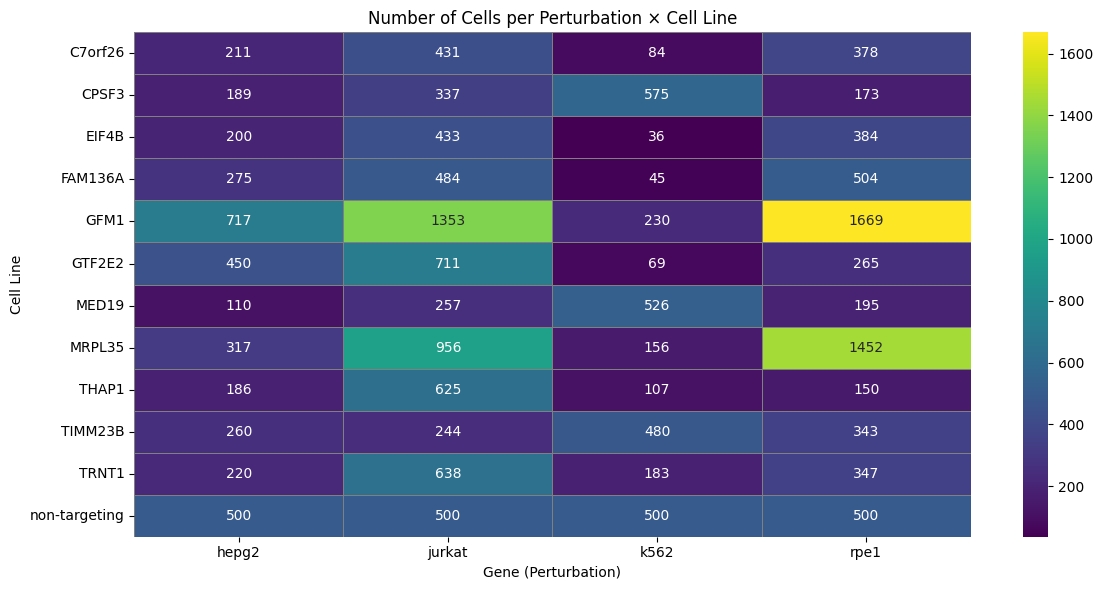

In [50]:
import seaborn as sns
import matplotlib.pyplot as plt

# Group counts
counts = adata_subset.obs.groupby(["cell_line", "gene"]).size().reset_index(name="n_cells")

# Pivot into cell_line x gene matrix
heatmap_data = counts.pivot(index="gene", columns="cell_line", values="n_cells").fillna(0)

# Plot
plt.figure(figsize=(12, 6))
ax = sns.heatmap(
    heatmap_data,
    cmap="viridis",        # or "magma", "coolwarm"
    linewidths=0.5,
    linecolor="gray",
    annot=True,            # <--- show real counts
    fmt="g",               # integer format (general)
    cbar=True
)

ax.set_xlabel("Gene (Perturbation)")
ax.set_ylabel("Cell Line")
ax.set_title("Number of Cells per Perturbation × Cell Line")

plt.tight_layout()
plt.show()

In [37]:
adata_subset.obs["cell_line"].value_counts()

cell_line
jurkat    6469
rpe1      5860
hepg2     3135
k562      2491
Name: count, dtype: int64

In [38]:
adata_subset

AnnData object with n_obs × n_vars = 17955 × 6642
    obs: 'gem_group', 'gene', 'gene_id', 'transcript', 'gene_transcript', 'sgID_AB', 'mitopercent', 'UMI_count', 'z_gemgroup_UMI', 'cell_line'
    var: 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'hvg'
    obsm: 'X_hvg'

In [39]:
out_path = "replogle_subset_seed3.h5ad"         # choose your output path

# (Optional) quick sanity print
print(f"Kept {adata_subset.n_obs} cells across {adata_subset.obs[obs_key].nunique()} perturbations.")

# Save (keeps .X, .layers, .obsm, .varm, etc.)
adata_subset.write_h5ad(out_path)
print(f"Saved to: {out_path}")

Kept 18732 cells across 11 perturbations.
Saved to: replogle_subset_seed3.h5ad


In [41]:
import numpy as np
import pandas as pd
import anndata as ad

def subset_with_balanced_controls(
    adata_replogle: ad.AnnData,
    chosen: list,
    obs_key: str = "condition",          # perturbation label column
    control_label: str = "control",      # value in obs_key that marks controls
    line_key: str = "cell_line",         # column identifying cell lines
    controls_target_n: int = 2000,
    out_path: str = "replogle_subset_with_ctrls.h5ad",
    random_state: int = 42,
):
    rng = np.random.default_rng(random_state)

    # --- 1) subset to chosen perturbations ---
    chosen_set = set(chosen)
    mask_perts = adata_replogle.obs[obs_key].isin(chosen_set)
    adata_perts = adata_replogle[mask_perts].copy()

    # --- 2) get eligible controls and split evenly by cell line ---
    obs = adata_replogle.obs
    if line_key not in obs.columns:
        raise KeyError(f"Column '{line_key}' not found in adata.obs")

    ctrl_mask = obs[obs_key] == control_label
    ctrl_obs = obs.loc[ctrl_mask, [line_key]]

    if ctrl_obs.empty:
        raise ValueError(f"No control cells found where {obs_key} == '{control_label}'.")

    # counts per line
    line_counts = ctrl_obs[line_key].value_counts()
    lines = line_counts.index.tolist()
    n_lines = len(lines)

    # base quota per line + fairly distribute remainder
    base = controls_target_n // n_lines
    remainder = controls_target_n % n_lines
    # randomize which lines get the +1 remainder for fairness
    lines_shuffled = pd.Index(lines).to_series().sample(frac=1, random_state=random_state).tolist()
    remainder_set = set(lines_shuffled[:remainder])

    # sample indices per line
    sampled_ctrl_indices = []
    for line in lines:
        need = base + (1 if line in remainder_set else 0)
        idx_line = ctrl_obs.index[ctrl_obs[line_key] == line]
        # sample up to what's available
        n_take = min(need, len(idx_line))
        if n_take > 0:
            take_idx = pd.Index(idx_line).to_series().sample(
                n=n_take, random_state=random_state
            ).index
            sampled_ctrl_indices.append(take_idx)

    if sampled_ctrl_indices:
        sampled_ctrl_indices = pd.Index(np.concatenate([idx.values for idx in sampled_ctrl_indices]))
    else:
        sampled_ctrl_indices = pd.Index([])

    # If we fell short (some lines had fewer than their quota), top up from remaining controls
    shortfall = controls_target_n - len(sampled_ctrl_indices)
    if shortfall > 0:
        remaining_pool = ctrl_obs.index.difference(sampled_ctrl_indices)
        n_topup = min(shortfall, len(remaining_pool))
        if n_topup > 0:
            topup_idx = pd.Index(remaining_pool).to_series().sample(
                n=n_topup, random_state=random_state
            ).index
            sampled_ctrl_indices = sampled_ctrl_indices.append(topup_idx)

    # Final control subset
    adata_ctrls = adata_replogle[sampled_ctrl_indices].copy()

    # --- 3) concat perturbations + controls ---
    adata_subset = ad.concat([adata_perts, adata_ctrls], join="inner", label=None)

    # --- 4) tidy up categoricals ---
    for col in adata_subset.obs.columns:
        if pd.api.types.is_categorical_dtype(adata_subset.obs[col]):
            adata_subset.obs[col] = adata_subset.obs[col].cat.remove_unused_categories()

    # --- 5) quick summary ---
    n_ctrl = int((adata_subset.obs[obs_key] == control_label).sum())
    n_perts = adata_subset.n_obs - n_ctrl
    per_line_ctrl_counts = (
        adata_subset.obs.loc[adata_subset.obs[obs_key] == control_label, line_key]
        .value_counts()
        .sort_index()
        .to_dict()
    )
    print(
        f"Subset cells: total={adata_subset.n_obs} | perturbation={n_perts} | control={n_ctrl} "
        f"(target ~{controls_target_n})"
    )
    print("Control cells per line:", per_line_ctrl_counts)

    if not sp.isspmatrix_csr(adata_subset.X):
        adata_subset.X = sp.csr_matrix(adata_subset.X)

    # --- 6) save ---
    adata_subset.write_h5ad(out_path, compression="lzf")
    print(f"Saved to: {out_path}")

    return adata_subset

In [44]:
# chosen: list of perturbation labels you already selected
# adata_replogle: AnnData already loaded

adata_subset = subset_with_balanced_controls(
    replogle,
    chosen=chosen,
    obs_key="gene",          # change if needed
    control_label="non-targeting",      # change if your control is labeled differently (e.g., "NTC")
    line_key="cell_line",         # change to your column (e.g., "line", "donor", etc.)
    controls_target_n=2000,
    out_path="replogle_even_split.h5ad",
    random_state=2,
)

/tmp/ipykernel_21241/2603219765.py:82: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(adata_subset.obs[col]):


Subset cells: total=19955 | perturbation=17955 | control=2000 (target ~2000)
Control cells per line: {'hepg2': 500, 'jurkat': 500, 'k562': 500, 'rpe1': 500}
Saved to: replogle_even_split.h5ad


/gpfs/home/asun/miniforge3/envs/perturbbench/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


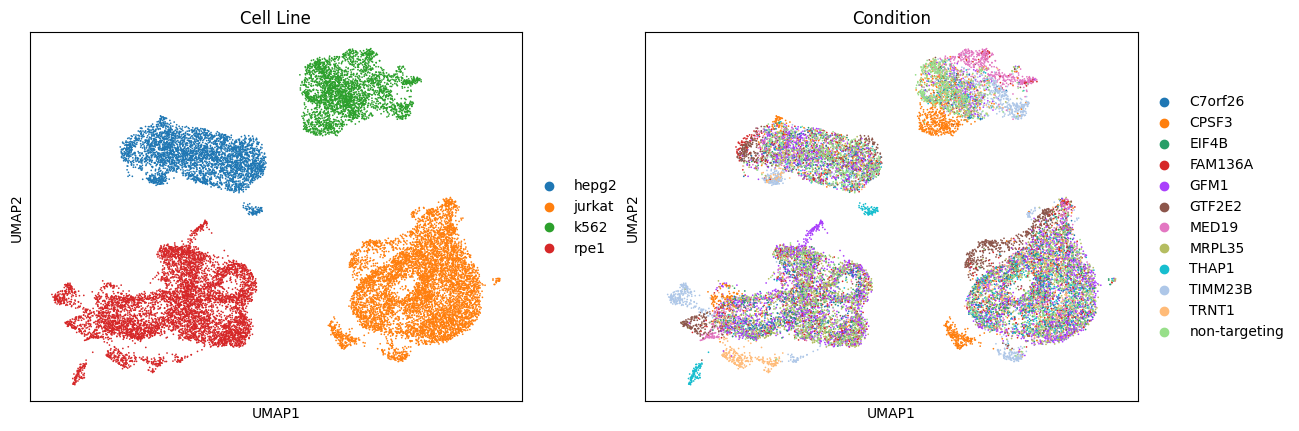

In [46]:
sc.pp.pca(adata_subset, n_comps = 50)
sc.pp.neighbors(adata_subset)
sc.tl.umap(adata_subset)
sc.pl.umap(adata_subset, color = ["cell_line", "gene"], title = ["Cell Line", "Condition"])

In [12]:
import yaml

# Load from a YAML file
with open("/gpfs/home/asun/jin_lab/perturbench/src/perturbench/src/perturbench/configs/data/splitter/saved_split.yaml", "r") as f:
    cfg = yaml.safe_load(f)

print(type(cfg))   # usually a dict
print(cfg)

<class 'dict'>
{'split_path': '/gpfs/home/asun/jin_lab/perturbench/1_train/logs/train/runs/2025-09-12_05-13-59/train_test_split.csv'}


In [13]:
from omegaconf import OmegaConf
splitter_config = OmegaConf.create(cfg)

In [15]:
replogle.obs.shape[0]

20732

In [7]:
replogle.obs["gene"].value_counts()

gene
GFM1             3969
MRPL36           3254
non-targeting    2000
PSMB5            1414
TRNT1            1388
TMEM214          1371
TIMM23B          1327
FAM136A          1308
CPSF3            1274
TMEM242          1265
MYBL2            1091
CLOCK            1071
Name: count, dtype: int64

In [21]:
split_dict = PerturbationDataSplitter.split_dataset(
    splitter_config,
    replogle.obs.copy(),
    perturbation_key='gene',
    perturbation_combination_delimiter="+",
    perturbation_control_value='non-targeting',
)
split_dict

{'train': array([    5,    13,    30, ..., 20727, 20729, 20730]),
 'val': array([    0,     2,     3, ..., 20716, 20726, 20731]),
 'test': array([    1,    19,    20, ..., 20720, 20723, 20728])}

In [17]:
balanced_transfer_splitter.obs_dataframe

AttributeError: 'dict' object has no attribute 'obs_dataframe'

In [19]:
seed_id = 1
balanced_transfer_split = balanced_transfer_splitter.split_covariates(
    seed=seed_id, 
    print_split=True, 
    max_heldout_fraction_per_covariate=0.6, ## Maximum fraction of perturbations held out per covariate
    max_heldout_covariates = 3,
    min_train_covariates = 2,
    max_heldout_perturbations_per_covariate = 3
)

Split summary: 
             train  val  test
('hepg2',)       8    2     3
('rpe1',)        9    3     2
('jurkat',)      8    2     3
('k562',)        5    3     2


/gpfs/group/jin/asun/perturbench/src/perturbench/src/perturbench/data/datasplitter.py:340: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for cov_keys, df in self.obs_dataframe.groupby(self.covariate_keys):
/gpfs/group/jin/asun/perturbench/src/perturbench/src/perturbench/data/datasplitter.py:348: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for pert_key, df in self.obs_dataframe.groupby([self.perturbation_key]):


In [1]:
print(balanced_transfer_splitter.obs_dataframe.groupby(["condition", "transfer_split_seed1", "cell_class"]).size())

NameError: name 'balanced_transfer_splitter' is not defined

In [8]:
generated_split = pd.read_csv("/gpfs/home/asun/jin_lab/perturbench/1_train/logs/train/runs/2025-09-12_05-09-18/train_test_split.csv")


NameError: name 'pd' is not defined

In [20]:

group_merged = balanced_transfer_splitter.obs_dataframe.merge(final_df, how = "left", left_on = ["cell_class2", "condition"], right_on = ["cell", "pert"])
group_merged.index = balanced_transfer_splitter.obs_dataframe.index

group_merged["group"] = group_merged["group"].fillna(group_merged[f'transfer_split_seed{seed_id}'])

NameError: name 'final_df' is not defined

In [26]:
balanced_transfer_splitter.obs_dataframe

,gem_group,gene,gene_id,transcript,gene_transcript,sgID_AB,mitopercent,UMI_count,z_gemgroup_UMI,cell_line,transfer_split_seed1
cell_barcode,,,,,,,,,,,
AAACCCAAGCAACAAT-16,16,TMEM214,ENSG00000119777,P1P2,9042_TMEM214_P1P2_ENSG00000119777,TMEM214_-_27255873.23-P1P2|TMEM214_-_27255853....,0.109515,8282.0,-0.214576,hepg2,val
AAACCCACAAGCTGCC-9,9,TRNT1,ENSG00000072756,P1P2,9319_TRNT1_P1P2_ENSG00000072756,TRNT1_-_3168701.23-P1P2|TRNT1_+_3168671.23-P1P2,0.097558,23422.0,0.738085,hepg2,test
AAACCCACAGAACTTC-38,38,GFM1,ENSG00000168827,P1P2,3346_GFM1_P1P2_ENSG00000168827,GFM1_-_158362387.23-P1P2|GFM1_+_158362379.23-P1P2,0.086946,12111.0,0.097814,hepg2,val
AAACCCACAGTTGAAA-54,54,TMEM242,ENSG00000215712,P1P2,9056_TMEM242_P1P2_ENSG00000215712,TMEM242_+_157744504.23-P1P2|TMEM242_-_15774457...,0.102098,10392.0,-0.674983,hepg2,val
AAACCCAGTACCCACG-12,12,GFM1,ENSG00000168827,P1P2,3346_GFM1_P1P2_ENSG00000168827,GFM1_-_158362387.23-P1P2|GFM1_+_158362379.23-P1P2,0.121255,19595.0,1.449562,hepg2,val
...,...,...,...,...,...,...,...,...,...,...,...
AACCATGGTTCCCAAA-43,43,non-targeting,non-targeting,non-targeting,11195_non-targeting_non-targeting_non-targeting,non-targeting_02855|non-targeting_01051,0.092076,8569.0,-0.580916,hepg2,train
GTGGCGTCAACCGGAA-48,48,non-targeting,non-targeting,non-targeting,11218_non-targeting_non-targeting_non-targeting,non-targeting_03044|non-targeting_00667,0.105173,26214.0,1.462169,hepg2,test
TCACGGGCAAAGACTA-12,12,non-targeting,non-targeting,non-targeting,11321_non-targeting_non-targeting_non-targeting,non-targeting_03731|non-targeting_02863,0.104656,14734.0,0.583206,hepg2,train


In [25]:
# start with all rows labeled None
balanced_transfer_splitter.obs_dataframe["transfer_split_seed1"] = None  

# fill according to the split_dict
for split_name, idxs in split_dict.items():
    balanced_transfer_splitter.obs_dataframe.iloc[idxs, balanced_transfer_splitter.obs_dataframe.columns.get_loc("transfer_split_seed1")] = split_name

In [29]:
count_long = balanced_transfer_splitter.obs_dataframe.groupby(["gene", "transfer_split_seed1", "cell_line"]).size().reset_index(name = "count")


/tmp/ipykernel_8318/2003223622.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  count_long = balanced_transfer_splitter.obs_dataframe.groupby(["gene", "transfer_split_seed1", "cell_line"]).size().reset_index(name = "count")


In [15]:
count_long

,condition,transfer_split_seed1,cell_class,count
0,ANK3,test,NP,0
1,ANK3,test,PT,0
2,ANK3,test,ctL6,489
3,ANK3,test,inhib,0
4,ANK3,test,itRSP,283
...,...,...,...,...
175,ctrl,val,NP,57
176,ctrl,val,PT,64
177,ctrl,val,ctL6,184
178,ctrl,val,inhib,54


/tmp/ipykernel_8318/2282787933.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  count_long = balanced_transfer_splitter.obs_dataframe.groupby(["gene", "transfer_split_seed1", "cell_line"]).size().reset_index(name = "count")


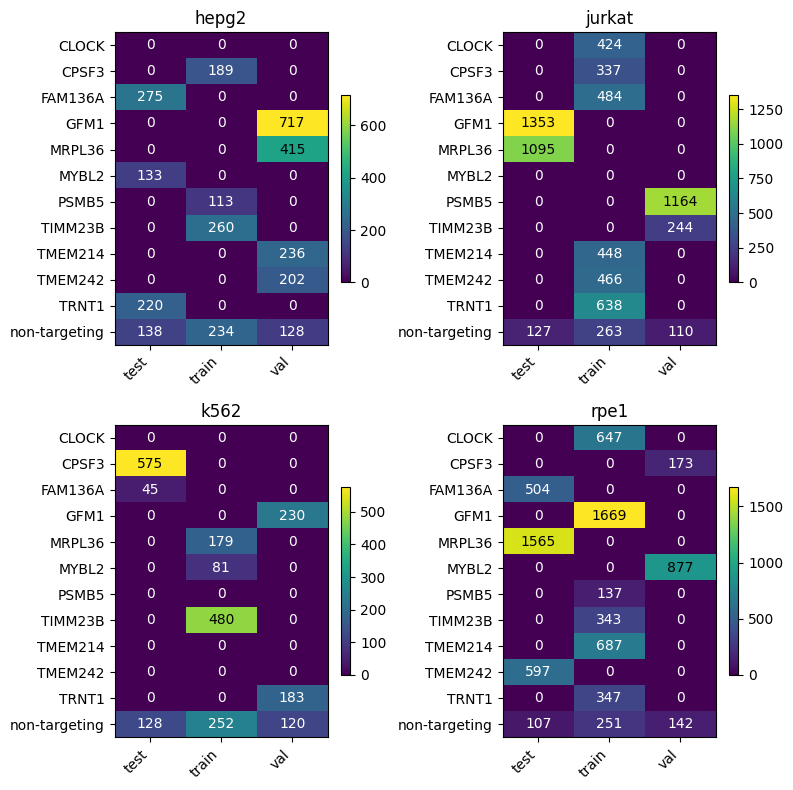

In [31]:
#count_long = balanced_transfer_splitter.obs_dataframe.groupby(["cell_class2", "condition", f"transfer_split_seed{seed_id}"]).size().reset_index(name = "count")
count_long = balanced_transfer_splitter.obs_dataframe.groupby(["gene", "transfer_split_seed1", "cell_line"]).size().reset_index(name = "count")

#cell_counts_all = count_long.pivot(index = ["cell_class2", "condition"], columns = f"transfer_split_seed{seed_id}", values = "count" ).reset_index()
cell_counts_all = count_long.pivot(index = ["cell_line", "gene"], columns = "transfer_split_seed1", values = "count" ).reset_index()

cell_counts_all.columns.name = ""
filtered = cell_counts_all.dropna(axis=0, how="all", subset=cell_counts_all.columns[2:])
cell_classes = filtered["cell_line"].unique()
n_cols = 2
n_rows = (len(cell_classes) + n_cols - 1) // n_cols

fig, axes = plt.subplots(n_rows, n_cols, figsize=(4 * n_cols, 4 * n_rows))
axes = axes.flatten()

for i, cell_class in enumerate(cell_classes):
    ax = axes[i]
    subset = filtered[filtered["cell_line"] == cell_class].set_index("gene")
    subset = subset.drop(columns="cell_line")
    subset = subset.fillna(0)
    data = subset.values

    im = ax.imshow(data, aspect="auto", cmap="viridis")
    ax.set_title(cell_class)
    ax.set_xticks(np.arange(subset.shape[1]))
    ax.set_xticklabels(subset.columns, rotation=45, ha="right")
    ax.set_yticks(np.arange(subset.shape[0]))
    ax.set_yticklabels(subset.index)

    for y in range(data.shape[0]):
        for x in range(data.shape[1]):
            value = data[y, x]
            if not np.isnan(value):
                ax.text(x, y, int(value), ha="center", va="center", color="white" if value < data.max() / 2 else "black")

    fig.colorbar(im, ax=ax, shrink=0.6)

for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

In [43]:
import pandas as pd

def stratified_subsample(df, frac, group_keys, random_state=42):
    """
    Subsample each unique group to a given fraction.

    Parameters
    ----------
    df : pd.DataFrame
        Your input dataframe.
    frac : float
        Fraction of rows to sample per group.
    group_keys : list[str]
        Column names to group by.
    random_state : int
        Seed for reproducibility.

    Returns
    -------
    pd.DataFrame
        Subsampled dataframe.
    """
    return (
        df.groupby(group_keys, group_keys=False, sort=False)
          .apply(lambda g: g.sample(frac=frac, random_state=random_state))
    )

# Example usage
group_cols = ["gene", "cell_line", "transfer_split_seed1"]

df_60 = stratified_subsample(balanced_transfer_splitter.obs_dataframe, frac=0.6, group_keys=group_cols, random_state=1)
df_20 = stratified_subsample(balanced_transfer_splitter.obs_dataframe, frac=0.2, group_keys=group_cols, random_state=2)

print("60% subsample:", df_60.shape)
print("20% subsample:", df_20.shape)

60% subsample: (12437, 11)
20% subsample: (4147, 11)


/tmp/ipykernel_8318/2962699784.py:24: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df.groupby(group_keys, group_keys=False, sort=False)
/tmp/ipykernel_8318/2962699784.py:25: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda g: g.sample(frac=frac, random_state=random_state))
/tmp/ipykernel_8318/2962699784.py:24: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the

In [35]:
balanced_transfer_splitter.obs_dataframe.shape

(20732, 11)

/tmp/ipykernel_8318/1672224353.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  count_long = df_20.groupby(["gene", "transfer_split_seed1", "cell_line"]).size().reset_index(name = "count")


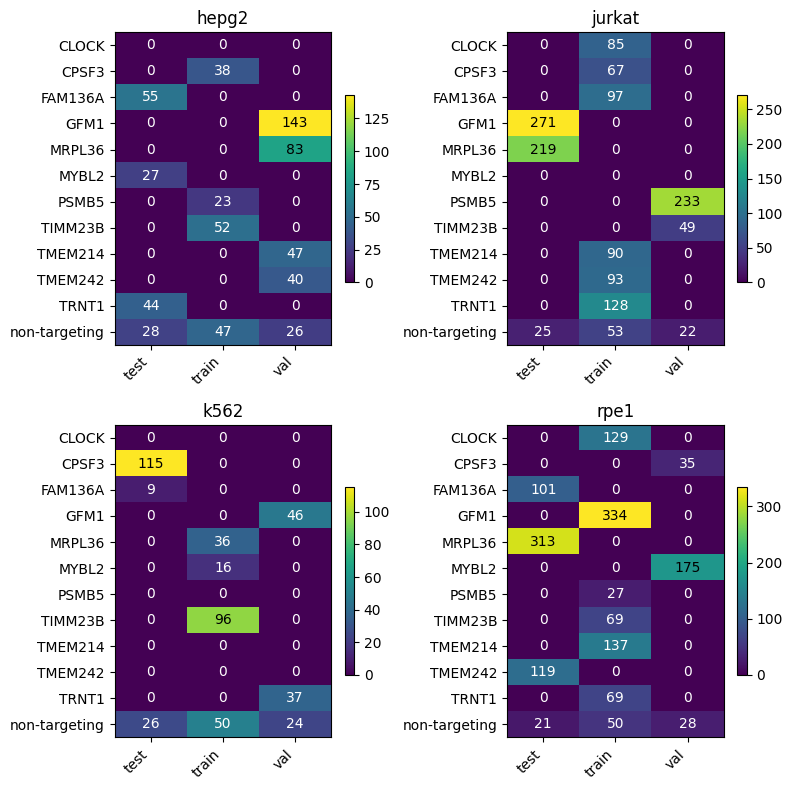

In [44]:
#count_long = balanced_transfer_splitter.obs_dataframe.groupby(["cell_class2", "condition", f"transfer_split_seed{seed_id}"]).size().reset_index(name = "count")
count_long = df_20.groupby(["gene", "transfer_split_seed1", "cell_line"]).size().reset_index(name = "count")

#cell_counts_all = count_long.pivot(index = ["cell_class2", "condition"], columns = f"transfer_split_seed{seed_id}", values = "count" ).reset_index()
cell_counts_all = count_long.pivot(index = ["cell_line", "gene"], columns = "transfer_split_seed1", values = "count" ).reset_index()

cell_counts_all.columns.name = ""
filtered = cell_counts_all.dropna(axis=0, how="all", subset=cell_counts_all.columns[2:])
cell_classes = filtered["cell_line"].unique()
n_cols = 2
n_rows = (len(cell_classes) + n_cols - 1) // n_cols

fig, axes = plt.subplots(n_rows, n_cols, figsize=(4 * n_cols, 4 * n_rows))
axes = axes.flatten()

for i, cell_class in enumerate(cell_classes):
    ax = axes[i]
    subset = filtered[filtered["cell_line"] == cell_class].set_index("gene")
    subset = subset.drop(columns="cell_line")
    subset = subset.fillna(0)
    data = subset.values

    im = ax.imshow(data, aspect="auto", cmap="viridis")
    ax.set_title(cell_class)
    ax.set_xticks(np.arange(subset.shape[1]))
    ax.set_xticklabels(subset.columns, rotation=45, ha="right")
    ax.set_yticks(np.arange(subset.shape[0]))
    ax.set_yticklabels(subset.index)

    for y in range(data.shape[0]):
        for x in range(data.shape[1]):
            value = data[y, x]
            if not np.isnan(value):
                ax.text(x, y, int(value), ha="center", va="center", color="white" if value < data.max() / 2 else "black")

    fig.colorbar(im, ax=ax, shrink=0.6)

for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

/tmp/ipykernel_21241/68996782.py:6: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  balanced_transfer_splitter.obs_dataframe.groupby(["gene", "transfer_split_seed1", "cell_line"])
/tmp/ipykernel_21241/68996782.py:21: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  balanced_transfer_splitter.obs_dataframe.groupby(["gene", "transfer_split_seed1", "cell_line"])


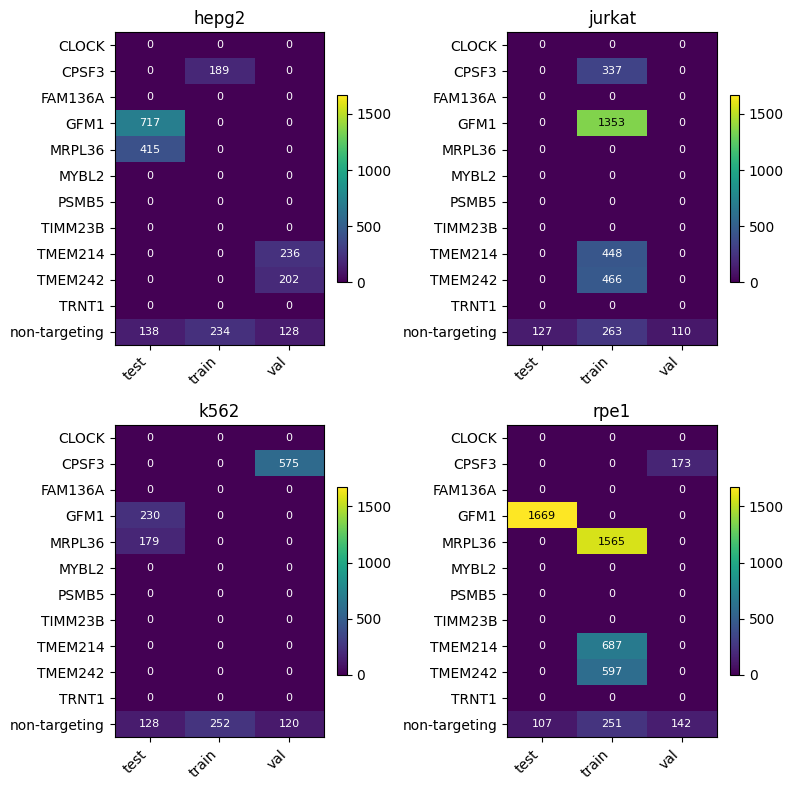

In [27]:
import numpy as np
import matplotlib.pyplot as plt

# --- compute global min/max from 100% sample ---
count_long_full = (
    balanced_transfer_splitter.obs_dataframe.groupby(["gene", "transfer_split_seed1", "cell_line"])
    .size()
    .reset_index(name="count")
)
cell_counts_all_full = count_long_full.pivot(
    index=["cell_line", "gene"],
    columns="transfer_split_seed1",
    values="count",
).reset_index()

global_min = cell_counts_all_full.drop(columns=["cell_line", "gene"]).min().min()
global_max = cell_counts_all_full.drop(columns=["cell_line", "gene"]).max().max()

# --- pivot current sample (df_60, df_20, etc.) ---
count_long = (
    balanced_transfer_splitter.obs_dataframe.groupby(["gene", "transfer_split_seed1", "cell_line"])
    .size()
    .reset_index(name="count")
)

cell_counts_all = count_long.pivot(
    index=["cell_line", "gene"],
    columns="transfer_split_seed1",
    values="count",
).reset_index()

cell_counts_all.columns.name = ""
filtered = cell_counts_all.dropna(axis=0, how="all", subset=cell_counts_all.columns[2:])
cell_classes = filtered["cell_line"].unique()

n_cols = 2
n_rows = (len(cell_classes) + n_cols - 1) // n_cols

fig, axes = plt.subplots(n_rows, n_cols, figsize=(4 * n_cols, 4 * n_rows))
axes = axes.flatten()

for i, cell_class in enumerate(cell_classes):
    ax = axes[i]
    subset = filtered[filtered["cell_line"] == cell_class].set_index("gene")
    subset = subset.drop(columns="cell_line").fillna(0)
    data = subset.values

    # use vmin/vmax from 100% sample
    im = ax.imshow(data, aspect="auto", cmap="viridis",
                   vmin=global_min, vmax=global_max)

    ax.set_title(cell_class)
    ax.set_xticks(np.arange(subset.shape[1]))
    ax.set_xticklabels(subset.columns, rotation=45, ha="right")
    ax.set_yticks(np.arange(subset.shape[0]))
    ax.set_yticklabels(subset.index)

    for y in range(data.shape[0]):
        for x in range(data.shape[1]):
            value = data[y, x]
            ax.text(
                x, y, int(value),
                ha="center", va="center",
                color="white" if value < (global_min + global_max) / 2 else "black",
                fontsize=8,
            )

    # individual colorbar for each subplot
    fig.colorbar(im, ax=ax, shrink=0.6)

# delete unused axes
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

# Subsample actual split + anndata with df60 and df20

In [45]:
df_60

,gem_group,gene,gene_id,transcript,gene_transcript,sgID_AB,mitopercent,UMI_count,z_gemgroup_UMI,cell_line,transfer_split_seed1
cell_barcode,,,,,,,,,,,
TCGCTTGCAGGTCCGT-34,34,TMEM214,ENSG00000119777,P1P2,9042_TMEM214_P1P2_ENSG00000119777,TMEM214_-_27255873.23-P1P2|TMEM214_-_27255853....,0.070178,33344.0,2.594901,hepg2,val
GCGGATCTCTTGGAAC-4,4,TMEM214,ENSG00000119777,P1P2,9042_TMEM214_P1P2_ENSG00000119777,TMEM214_-_27255873.23-P1P2|TMEM214_-_27255853....,0.092025,9041.0,-0.794929,hepg2,val
CGCCATTCACTTCAAG-55,55,TMEM214,ENSG00000119777,P1P2,9042_TMEM214_P1P2_ENSG00000119777,TMEM214_-_27255873.23-P1P2|TMEM214_-_27255853....,0.086265,58436.0,0.949842,hepg2,val
CTACCTGGTTACGGAG-35,35,TMEM214,ENSG00000119777,P1P2,9042_TMEM214_P1P2_ENSG00000119777,TMEM214_-_27255873.23-P1P2|TMEM214_-_27255853....,0.083521,33704.0,-0.366132,hepg2,val
TGATCAGCAGTCTCTC-13,13,TMEM214,ENSG00000119777,P1P2,9042_TMEM214_P1P2_ENSG00000119777,TMEM214_-_27255873.23-P1P2|TMEM214_-_27255853....,0.095065,11308.0,-0.674031,hepg2,val
...,...,...,...,...,...,...,...,...,...,...,...
TCGGGTGCACATCCCT-48,48,non-targeting,non-targeting,non-targeting,10785_non-targeting_non-targeting_non-targeting,non-targeting_00216|non-targeting_00857,0.079958,15083.0,-0.100293,hepg2,test
TTACCATAGAGGCGTT-8,8,non-targeting,non-targeting,non-targeting,11270_non-targeting_non-targeting_non-targeting,non-targeting_03462|non-targeting_00434,0.101299,12162.0,-0.811550,hepg2,test
CCTCAACAGGACACTG-13,13,non-targeting,non-targeting,non-targeting,11025_non-targeting_non-targeting_non-targeting,non-targeting_01813|non-targeting_00122,0.080872,19401.0,0.298076,hepg2,test


In [42]:
balanced_transfer_splitter.obs_dataframe

,gem_group,gene,gene_id,transcript,gene_transcript,sgID_AB,mitopercent,UMI_count,z_gemgroup_UMI,cell_line,transfer_split_seed1
cell_barcode,,,,,,,,,,,
AAACCCAAGCAACAAT-16,16,TMEM214,ENSG00000119777,P1P2,9042_TMEM214_P1P2_ENSG00000119777,TMEM214_-_27255873.23-P1P2|TMEM214_-_27255853....,0.109515,8282.0,-0.214576,hepg2,val
AAACCCACAAGCTGCC-9,9,TRNT1,ENSG00000072756,P1P2,9319_TRNT1_P1P2_ENSG00000072756,TRNT1_-_3168701.23-P1P2|TRNT1_+_3168671.23-P1P2,0.097558,23422.0,0.738085,hepg2,test
AAACCCACAGAACTTC-38,38,GFM1,ENSG00000168827,P1P2,3346_GFM1_P1P2_ENSG00000168827,GFM1_-_158362387.23-P1P2|GFM1_+_158362379.23-P1P2,0.086946,12111.0,0.097814,hepg2,val
AAACCCACAGTTGAAA-54,54,TMEM242,ENSG00000215712,P1P2,9056_TMEM242_P1P2_ENSG00000215712,TMEM242_+_157744504.23-P1P2|TMEM242_-_15774457...,0.102098,10392.0,-0.674983,hepg2,val
AAACCCAGTACCCACG-12,12,GFM1,ENSG00000168827,P1P2,3346_GFM1_P1P2_ENSG00000168827,GFM1_-_158362387.23-P1P2|GFM1_+_158362379.23-P1P2,0.121255,19595.0,1.449562,hepg2,val
...,...,...,...,...,...,...,...,...,...,...,...
AACCATGGTTCCCAAA-43,43,non-targeting,non-targeting,non-targeting,11195_non-targeting_non-targeting_non-targeting,non-targeting_02855|non-targeting_01051,0.092076,8569.0,-0.580916,hepg2,train
GTGGCGTCAACCGGAA-48,48,non-targeting,non-targeting,non-targeting,11218_non-targeting_non-targeting_non-targeting,non-targeting_03044|non-targeting_00667,0.105173,26214.0,1.462169,hepg2,test
TCACGGGCAAAGACTA-12,12,non-targeting,non-targeting,non-targeting,11321_non-targeting_non-targeting_non-targeting,non-targeting_03731|non-targeting_02863,0.104656,14734.0,0.583206,hepg2,train


In [46]:
# df_60 is your subsampled dataframe with cell barcodes as index
out = df_60[["transfer_split_seed1"]].copy()

# write both the index and the column
out.to_csv("replogle_df_60_train_test_split.csv", index=True, index_label="cell_barcode")

In [47]:
# df_60 is your subsampled dataframe with cell barcodes as index
out = df_20[["transfer_split_seed1"]].copy()

# write both the index and the column
out.to_csv("replogle_df_20_train_test_split.csv", index=True, index_label="cell_barcode")

In [48]:
# assuming balanced_transfer_splitter.obs_dataframe.index == adata.obs.index
# and df_60 / df_20 have cell barcodes as index

adata_60 = replogle[df_60.index].copy()
adata_20 = replogle[df_20.index].copy()

print(adata_60)
print(adata_20)

AnnData object with n_obs × n_vars = 12437 × 6642
    obs: 'gem_group', 'gene', 'gene_id', 'transcript', 'gene_transcript', 'sgID_AB', 'mitopercent', 'UMI_count', 'z_gemgroup_UMI', 'cell_line'
    obsm: 'X_hvg'
AnnData object with n_obs × n_vars = 4147 × 6642
    obs: 'gem_group', 'gene', 'gene_id', 'transcript', 'gene_transcript', 'sgID_AB', 'mitopercent', 'UMI_count', 'z_gemgroup_UMI', 'cell_line'
    obsm: 'X_hvg'


In [49]:
adata_60.write_h5ad("/gpfs/home/asun/jin_lab/perturbench/0_datasets/replogle_subset_seed2_with_ctrls_sparse_60.h5ad")
adata_20.write_h5ad("/gpfs/home/asun/jin_lab/perturbench/0_datasets/replogle_subset_seed2_with_ctrls_sparse_20.h5ad")
